In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import os
from os.path import join, basename, exists

import urllib.request
import numpy as np
import cv2
import torch
from PIL import Image

In [12]:
from lib.r2d2.extract import extract_keypoints_modified

from relfm.utils.visualize import show_single_image, show_grid_of_images, show_keypoint_matches

In [4]:
def download_file(url, path):
    """Downloads file at URL `url` to local path `path`."""
    urllib.request.urlretrieve(url, path)

In [6]:
# download model checkpoint

URL = "https://github.com/naver/r2d2/raw/master/models/r2d2_WASF_N16.pt"

model_dir = "../checkpoints/"
os.makedirs(model_dir, exist_ok=True)

path = join(model_dir, basename(URL))
if not exists(path):
    download_file(URL, path)

In [7]:
# check downloaded file
# ckpt = np.load(path, allow_pickle=True)
ckpt = torch.load(path)

In [8]:
ckpt.keys()

dict_keys(['net', 'state_dict'])

In [54]:
img1_path = "../sample_images/house1.png"
img2_path = "../sample_images/house2.png"

img1 = Image.open(img1_path).convert('RGB')
img2 = Image.open(img2_path).convert('RGB')

In [163]:
rotation = 60
if rotation == 0:
    img2_rotated = img2
else:
    img2_rotated = img2.rotate(rotation)

images = [img1, img2_rotated]
np_images = [np.asarray(x) for x in images]

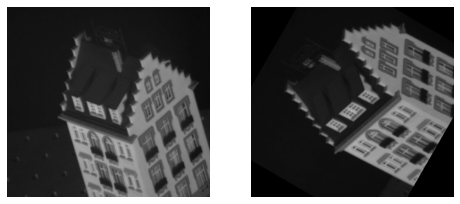

In [164]:
show_grid_of_images(np_images, n_cols=2)

In [165]:
outputs = extract_keypoints_modified(images, path)

Launching on CPU

>> Creating net = Quad_L2Net_ConfCFS()
 ( Model size: 486K parameters )
extracting at scale x1.00 =  512x480
extracting at scale x0.84 =  431x404
extracting at scale x0.71 =  362x339
extracting at scale x0.59 =  304x285
extracting at scale x0.50 =  256x240
extracting at scale x1.00 =  512x480
extracting at scale x0.84 =  431x404
extracting at scale x0.71 =  362x339
extracting at scale x0.59 =  304x285
extracting at scale x0.50 =  256x240


In [166]:
len(outputs)

2

In [167]:
outputs[0]["keypoints"].shape

(2615, 3)

In [168]:
def add_kps_to_image(img: np.ndarray, kps: np.ndarray):
    
    N = kps.shape[0]
    if kps.shape[1] == 2:
        kps = np.concatenate(kps, np.ones((N, 1)), axis=1)
    assert kps.shape == (N, 3)

    kps = [cv2.KeyPoint(*coord) for coord in kps]
    img_with_kps = cv2.drawKeypoints(img, kps, np.array([]), (255,0,0))
    
    return img_with_kps, kps

In [169]:
images_with_kps = []
kps_per_image = []

for i in range(len(outputs)):
    img_with_kps, kps = add_kps_to_image(np_images[i], outputs[i]["keypoints"])
    
    images_with_kps.append(img_with_kps)
    kps_per_image.append(kps)

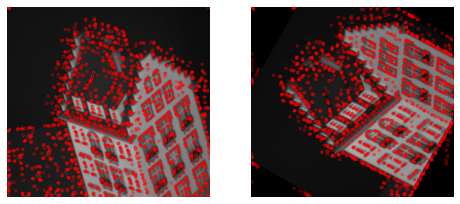

In [170]:
show_grid_of_images(images_with_kps, n_cols=2)

In [171]:
def mnn_matcher(descriptors_a, descriptors_b):
    """
    Borrowed from: D2Net's HPatches benchmark notebook.
    Link: https://github.com/mihaidusmanu/d2-net/blob/master/hpatches_sequences/HPatches-Sequences-Matching-Benchmark.ipynb
    """
    device = descriptors_a.device
    sim = descriptors_a @ descriptors_b.t()
    nn12 = torch.max(sim, dim=1)[1]
    nn21 = torch.max(sim, dim=0)[1]
    ids1 = torch.arange(0, sim.shape[0], device=device)
    mask = (ids1 == nn21[nn12])
    matches = torch.stack([ids1[mask], nn12[mask]])
    dist = 1- sim[[matches[0], matches[1]]]
    return dist.data.cpu().numpy(), matches.t().data.cpu().numpy()


def find_matches(des1: np.ndarray, des2: np.ndarray):
    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    
    # compute pairwise distances
    dist, _matches = mnn_matcher(torch.from_numpy(des1), torch.from_numpy(des2))

    # sort based on distances
    order = np.argsort(dist)
    _matches = _matches[order]
    dist = dist[order]
    
    # create cv2.DMatch objects
    matches = []
    for (x, y), d in zip(_matches, np.round(dist, 1)):
        matches.append(cv2.DMatch(_queryIdx=x, _trainIdx=y, _distance=d))
    
    return matches

In [172]:
matches = find_matches(outputs[0]["descriptors"], outputs[1]["descriptors"])

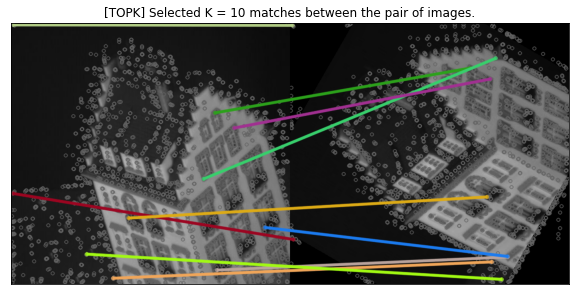

In [173]:
matches_img = show_keypoint_matches(
    np_images[0], kps_per_image[0], np_images[1], kps_per_image[1], matches, choose_matches="topk"
)